# Anomaly Detection in Time Series Tutorial #
This notebook is based on the tutorial at: https://www.youtube.com/watch?v=qy41dXGbAxY&t=817s  <br>
<br>
Github for the tutorial is: https://github.com/marcopeix/youtube_tutorials/blob/main/YT_02_anomaly_detection_time_series.ipynb <br>
<br>
Github source for the data is: https://github.com/numenta/NAB/blob/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv <br>
<br>
Github source for the labels is: https://github.com/numenta/NAB/blob/master/labels/combined_labels.json <br>
<br>
The Numenta Anomaly Benchmark (NAB) data repository is available via AGPL-3.0 license and is a very good repository of anomaly detection data.  

### Agenda ###
  * Types of Anomaly Detection tasks in time series
  * Mean Absolute Deviation (MAD)
  * Isolation Forest
  * Local Outlier Factor (LOF)

#### Types of Anomaly Detection ####
  * Point-wise Anomaly Detection
  * Pattern-wise Anomaly Detection

#### Mean Absolute Deviation ####

Danger! <br>
Robust Z-score works only if the data is close to a normal distribution.<br>
The MAD is not equal to 0 (happens when more than 50% of the data has the same value)

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [4]:
df = pd.read_csv('data/ec2_cpu_utilization.csv') # Previously downloaded and saved in ./data/
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [5]:
# Labels taken from the link above.  We are looking at the labels for ec2_cpu_utilization for the specified dates
anomalies_timestamp =[
    "2014-02-26 22:05:00",
    "2014-02-27 17:15:00"
]

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [7]:
# Add anomaly label
df['is_anomaly'] = 1   # scikit-learn standard.  1 is an "inlier", -1 is an anomaly, so we start everything at 1.

for each in anomalies_timestamp:
    df.loc[df['timestamp']==each, 'is_anomaly'] = -1

df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


#### Visualize the data

In [8]:
anomaly_df = df.loc[df['is_anomaly']==-1]
inlier_df = df.loc[df['is_anomaly']==1]

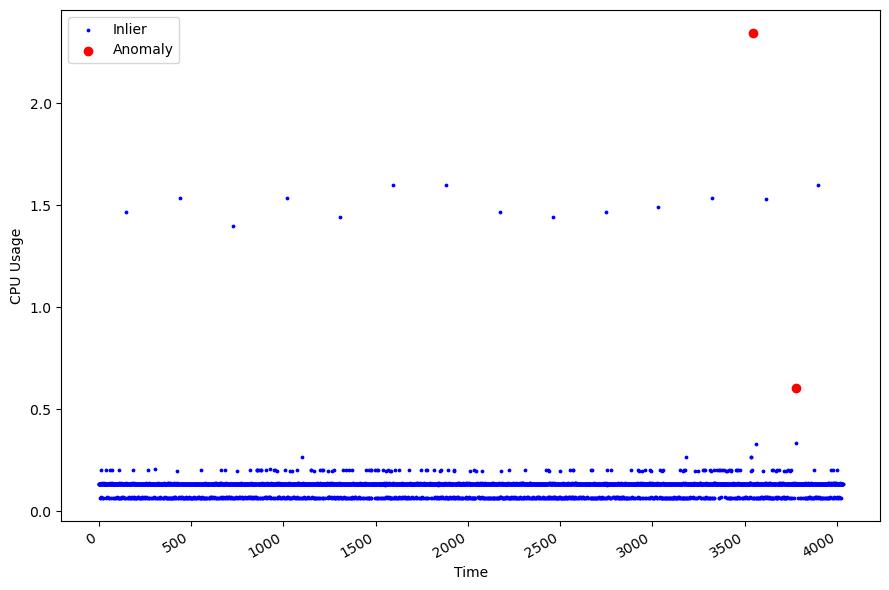

In [9]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label ='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU Usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

#### Baseline: Mean Absolute Deviation - MAD ####
When the data is normally distributed, reasonably conclude that outliers are at the tails of the distribution. <br>
<br>
Calculated using Z-score:<br>
$$
Z = \frac{x - \mu}{\sigma}
$$
<br>
This formula calculates how many standard deviations an observation 
𝑥
x is away from the mean 
𝜇
μ.<br>



Outliers affect Z-score, therefore we need something better.  The Robust Z-Score method uses the median instead of the mean.<br>
$$ \mathrm{MAD} = \mathrm{median} \left( \left| x_i - \mathrm{median}(x) \right| \right) $$

When calculating Median Absolute Deviation (MAD) as a robust measure of scale, it is often scaled by a factor of 0.6745 to make it comparable to the standard deviation for normally distributed data.

Adjusted MAD Formula:
The adjusted MAD formula is:
$$ \mathrm{MAD}_{\mathrm{adjusted}} = 1.4826 \times \mathrm{median}\left(\left| x_i - \mathrm{median}(x) \right|\right) $$  
<br>
<br>
1.4826: This is the reciprocal of 0.6745 (i.e., 1/0.6745 ≈ 1.4826).  The value 0.6745 is the 75th percentile of a standard normal distribution's absolute deviations around the median, meaning that 0.6745 standard deviations from the mean captures roughly half of the normal data. <br><br>
By multiplying by 
1
/
0.6745
≈
1.4826
1/0.6745≈1.4826, we scale MAD to be comparable to the standard deviation in a normal distribution. This adjusted MAD is often used because the raw MAD tends to underestimate variability in normally distributed data.


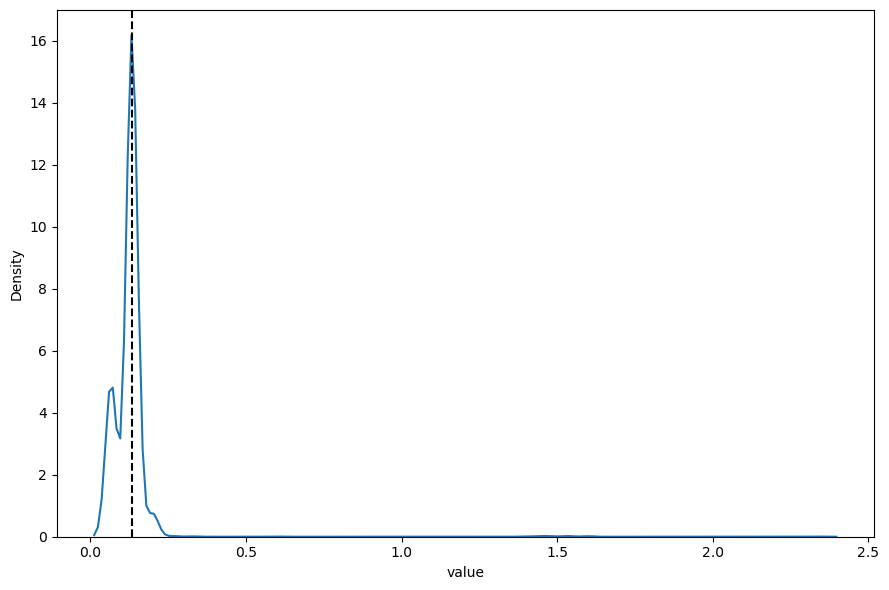

In [10]:
import seaborn as sns

sns.kdeplot(df['value']);
plt.grid(False)
plt.axvline(0.134, 0,1, c='black', ls='--')
plt.tight_layout()

#### Red Flags for MAD! ####
Not a normal distribution (scewed left quite far).  Plus it looks like the median (vertial black line) is on more than 50% of the data.

In [13]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(df['value'])
median = np.median(df['value'])

print("MAD: " + str(mad))
print("Median: " + str(median))

def compute_robust_z_score(x):
    return 0.6745*(x-median)/mad

MAD: 0.0020000000000000018
Median: 0.134


In [14]:
# Compute the robust Z-score for each sample
df['z-score'] = df['value'].apply(compute_robust_z_score)
df.head()

,timestamp,value,is_anomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


In [19]:
# Determine if it is an anomaly (use a threshold of 3.5)
df['baseline']=1
df.loc[df['z-score']>=3.5, 'baseline'] = -1
df.loc[df['z-score']<=-3.5, 'baseline'] = -1
df.head()

,timestamp,value,is_anomaly,z-score,baseline
0,2014-02-14 14:30:00,0.132,1,-0.6745,1
1,2014-02-14 14:35:00,0.134,1,0.0000,1
2,2014-02-14 14:40:00,0.134,1,0.0000,1
3,2014-02-14 14:45:00,0.134,1,0.0000,1
4,2014-02-14 14:50:00,0.134,1,0.0000,1


#### Visualize the confusion matrix ####

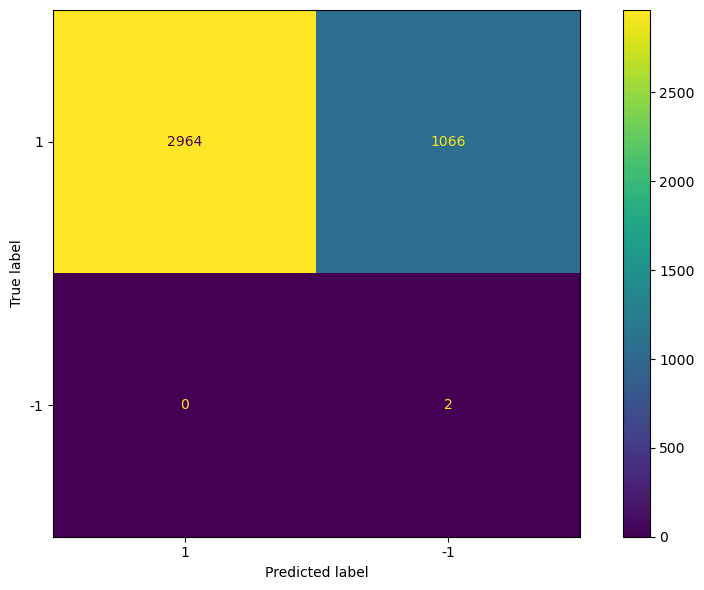

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot the confusion matrix
cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1,-1])
disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1,-1])
disp_cm.plot();
plt.grid(False)
plt.tight_layout()

Looking at the confusion matrix, we see that the two anomalies were predicted as anomalies, unfortunately, so were 1066 other non-anomalous points.  We kind of knew this would happen because all of the data was so tightly packed around the median

### Isolation Forest ###
 Tree based algorithm to detect outliers <br>
 Partitions the data to isolate points.<br>
   * Many partitions = Inlier
   * Few partitions = Outlier

In [21]:
from sklearn.ensemble import IsolationForest

In [ ]:
# Split the data (keep on anomaly in the test set)
train = df[:3550] # First section, keeps one anomaly
test = df[3550:] # second setion, keeps one anomaly


In [23]:
contamination = 1/len(train)

iso_forest = IsolationForest(contamination=contamination, random_state=42)

X_train = train['value'].values.reshape(-1,1)
iso_forest.fit(X_train)

IsolationForest(contamination=0.00028169014084507044, random_state=42)

In [24]:
preds_iso_forest = iso_forest.predict(test['value'].values.reshape(-1,1))

#### Visualize the confusion matrix again

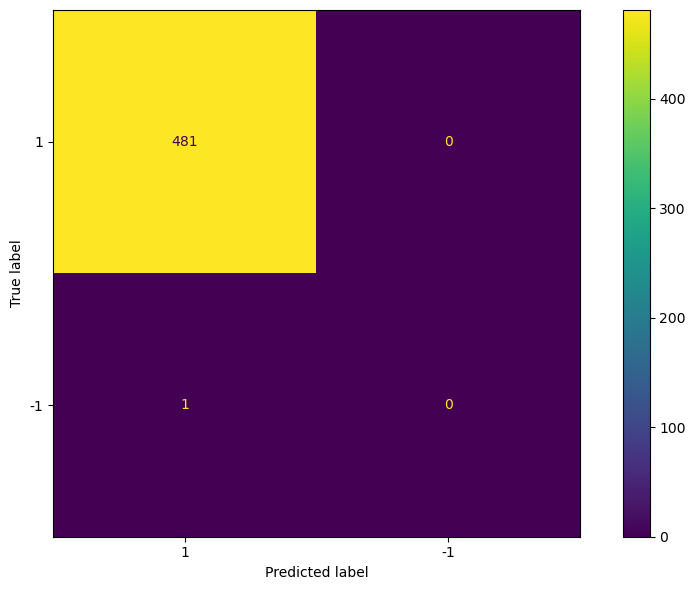

In [25]:
# Plot the confusion matrix
cm = confusion_matrix(test['is_anomaly'], preds_iso_forest, labels=[1,-1])
disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1,-1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()


Looking at this confusion matrix, The isolation forest did not find the anomaly.  It labeled every point as an inlier.  

### Local Outlier Factor (LOF) ###
  * Unsupervised method for anomaly detection
  * Intuition: compare the local density of a point to that of its neighbors
  * If the density is smaller, then the point is isolated, and therefore an outlier.
  * Based on Reachability Distance<br>
  $$
\text{reachability\_dist}_{k}(o, p) = \max(\text{k-distance}(o), \text{distance}(o, p))
$$


In [26]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(contamination=contamination, novelty=True)

lof.fit(X_train)

LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)

In [27]:
preds_lof = lof.predict(test['value'].values.reshape(-1,1))

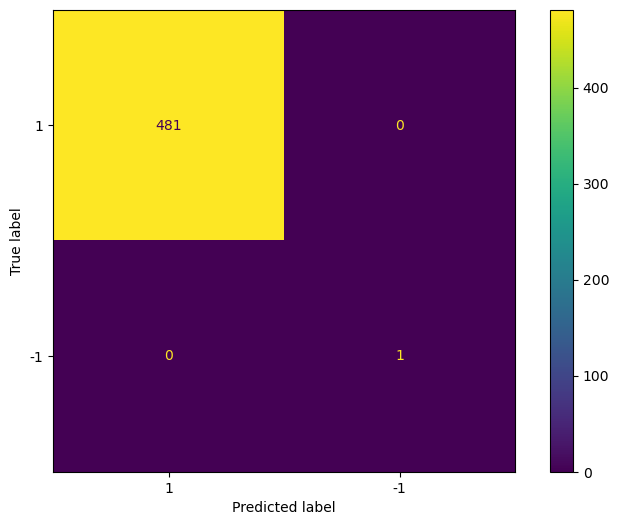

In [28]:
cm = confusion_matrix(test['is_anomaly'], preds_lof, labels=[1,-1])
disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1,-1])
disp_cm.plot();

This method produces a perfect confusion matrix.  It detected the anomaly and did not predict anomalies for all of the baseline points.